In [12]:
from PIL import Image
import os
import matplotlib.pyplot as plt
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import pylab
pylab.rcParams['figure.figsize'] = (4.0, 4.0)
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import torchvision.transforms as tvt
# from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sns
import copy
import gc

### Load the COCO dataset and data cleaning.

### Data preparation and cleaning.
1. There are some images containing multiple categories from the list. Delete them.
2. There are some gray scale images. Convert them to RGB images by duplicating the single channel.

In [2]:
# create a class of coco
annFile = 'F:\\0Course\\Deep_Learning\\HW\\annotations\\instances_train2014.json'
coco=COCO(annFile)

Folder_origin = 'F:\\0Course\\Deep_Learning\\HW\\train2014'
Folder_new = 'F:\\0Course\\Deep_Learning\\HW\\train'

loading annotations into memory...
Done (t=11.93s)
creating index...
index created!


In [3]:
# display COCO categories and supercategories
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(' '.join(nms)))

nms = set([cat['supercategory'] for cat in cats])
print('COCO supercategories: \n{}'.format(' '.join(nms)))

COCO categories: 
person bicycle car motorcycle airplane bus train truck boat traffic light fire hydrant stop sign parking meter bench bird cat dog horse sheep cow elephant bear zebra giraffe backpack umbrella handbag tie suitcase frisbee skis snowboard sports ball kite baseball bat baseball glove skateboard surfboard tennis racket bottle wine glass cup fork knife spoon bowl banana apple sandwich orange broccoli carrot hot dog pizza donut cake chair couch potted plant bed dining table toilet tv laptop mouse remote keyboard cell phone microwave oven toaster sink refrigerator book clock vase scissors teddy bear hair drier toothbrush

COCO supercategories: 
furniture food electronic indoor vehicle person accessory sports animal appliance outdoor kitchen


Note: 
1. there are some images containing multiple categories from the list, don't choose them
2. there are some gray scale images, duplicate for three channel

In [4]:
# load image within the category list
cat_list = ['airplane','bus','cat','dog','pizza']
cat_imgIds = []
cat_path_train = []
cat_path_valid = []

for cat in cat_list:
    catIds = coco.getCatIds(catNms=[cat])
    
    # get rid of the cross category images
    imgIds2 = []
    for cat2 in cat_list:
        if cat2 != cat:
            catIds2 = coco.getCatIds(catNms=[cat2])
            imgIds2 += coco.getImgIds(catIds=catIds2)
    imgIds = coco.getImgIds(catIds=catIds)
    imgIds = list(set(imgIds) - set(imgIds2))
    cat_imgIds.append(imgIds)
    
    # get the imgIds for training the validation data
    random.seed(10)
    imgIds_select = random.sample(imgIds, 2000)
    
    imgPath_select = []
    for Id in imgIds_select:
        img = coco.loadImgs(Id)
        FileName = img[0]['file_name']
        imgPath_select.append(FileName)
        # Call resize function to resize all images and save them to folder_new
        # resize_img(Folder_origin, Folder_new, FileName)
    cat_path_train.append(imgPath_select[:1500])
    cat_path_valid.append(imgPath_select[1500:])
    
# img = coco.loadImgs(imgIds[0:5])[0]

# 1-d data and label
train_path = []
train_label = []
valid_path = []
valid_label = []

for i in range(len(cat_list)):
    train_path += cat_path_train[i]
    train_label += [i]*len(cat_path_train[i])
    
    valid_path += cat_path_valid[i]
    valid_label += [i]*len(cat_path_valid[i])

In [5]:
coco.loadImgs(Id)[0]

{'license': 2,
 'file_name': 'COCO_train2014_000000566301.jpg',
 'coco_url': 'http://images.cocodataset.org/train2014/COCO_train2014_000000566301.jpg',
 'height': 640,
 'width': 425,
 'date_captured': '2013-11-20 23:57:36',
 'flickr_url': 'http://farm6.staticflickr.com/5174/5453733317_04f6a5628a_z.jpg',
 'id': 566301}

#### A function to resize the image and save it to a new folder

In [6]:
Folder_origin = 'F:\\0Course\\Deep_Learning\\HW\\train2014'
Folder_new = 'F:\\0Course\\Deep_Learning\\HW\\train'

def resize_img(Folder_origin, Folder_new, FileName):
        
    os.chdir(Folder_origin)
    I = Image.open(FileName)
    I_resize = I.resize((64,64))
    
    os.chdir(Folder_new)
    if I_resize.mode != 'RGB':
        # print(I.mode, FileName, end = '\n')
        I_rgb = Image.new('RGB', I_resize.size)
        I_rgb.paste(I_resize)
        I_rgb.save(FileName)
    else:
        I_resize.save(FileName)
        
    # os.chdir(Folder_new)
    # I_resize.save(FileName)

# for i in range(len(train_path)):
#     resize_img(Folder_origin, Folder_new, train_path[i])
# for i in range(len(valid_path)):
#     resize_img(Folder_origin, Folder_new, valid_path[i])

### Figure1: Plot 3*images for each category after resizing to 64x64

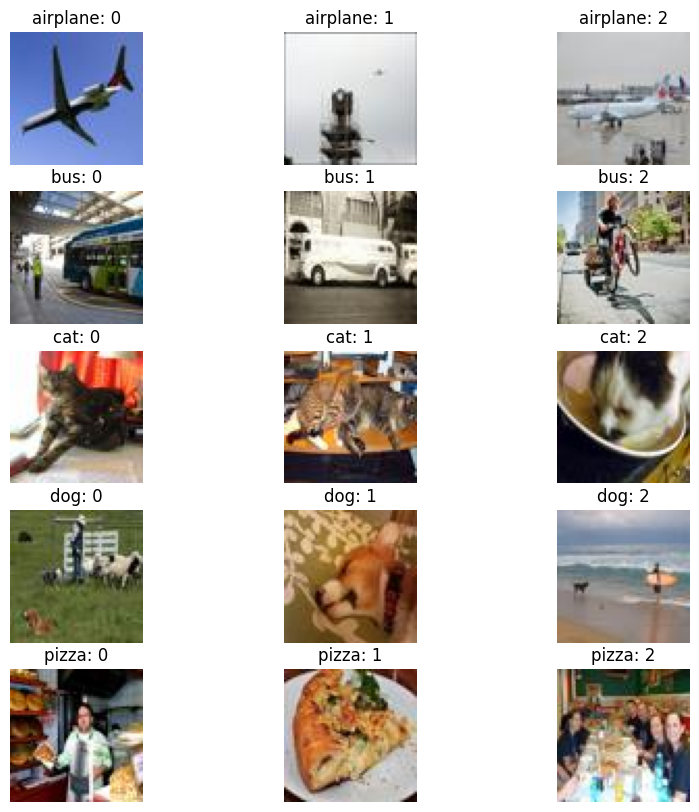

In [13]:
fig, ax = plt.subplots(5,3, figsize = (10,10))
os.chdir(Folder_new)
for i in range(5):
    for j in range(3):
        img = Image.open(cat_path_train[i][j])
        ax[i,j].imshow(img)
        ax[i,j].axis('off')
        ax[i,j].set_title(cat_list[i]+': '+str(j))
# print('-'*40,'Figure 1', '-'*40)

### Create dataloader with augmentation

In [8]:
# create dataset class
class MyDataset(torch.utils.data.Dataset):
    
    def __init__(self, Folder, train_path, train_label, train = True):
        super(MyDataset).__init__()
        self.Folder = Folder
#         os.chdir(self.root)
        self.train_path = train_path
        self.train_label = train_label
        # Initialize data augmentation transformation, etc.
        # self.Random_transform = tvt.RandomAffine(90, translate=(0.3,0.3), scale= (0.8, 1.2), shear=None)
        if train == True:
            self.Random_transform = tvt.Compose([tvt.ToTensor(),
                                                 tvt.RandomAffine(degrees = 20, translate=(0.2,0.2), scale= (0.8, 1.2), shear=None),
                                                 tvt.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])])
        else:
            # no transform is needed for testing data
            self.Random_transform = tvt.Compose([tvt.ToTensor(),
                                                 tvt.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])])
            
    def __len__(self):
        # return total num of images
        return len(self.train_path)
    
    def __getitem__(self, index):
        # Read an image at index and perform augmentations
        path = os.path.join(self.Folder, self.train_path[index])
        im = Image.open(path)
        # return the tuple: augmented tensor, integer label
        im_aug = self.Random_transform(im)
        label = self.train_label[index]
        return im_aug, label

### Create dataloader

In [9]:
myDataset_train = MyDataset(Folder_new, train_path, train_label)

kwargs = {'batch_size': 16,
          'shuffle': True,
          'drop_last': True}

train_data_loader = torch.utils.data.DataLoader(dataset = myDataset_train, **kwargs)

myDataset_valid = MyDataset(Folder_new, valid_path, valid_label, train=False)

kwargs = {'batch_size': 16, # len(myDataset_valid),
          'shuffle': True,
          'drop_last': True}

valid_data_loader = torch.utils.data.DataLoader(dataset = myDataset_valid, **kwargs)

In [10]:
next(iter(train_data_loader));

### Function to run training, validation and calculate confusion matrix

In [11]:
def run_training(net, lr, batch_size, epochs, myDataset_train=myDataset_train, myDataset_valid=myDataset_valid):
    net = copy.deepcopy(net)
    net = net.to(device)
    epochs = epochs
    criterion = torch.nn.CrossEntropyLoss()
    criterion_valid = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr = 1e-3)
    
    # create data loader
    kwargs = {'batch_size': batch_size,
              'shuffle': True,
              'drop_last': True}
    train_data_loader = torch.utils.data.DataLoader(dataset = myDataset_train, **kwargs)
    
    kwargs = {'batch_size': len(myDataset_valid),
              'shuffle': True,
              'drop_last': True}
    valid_data_loader = torch.utils.data.DataLoader(dataset = myDataset_valid, **kwargs)
    
    iter_valid = iter(valid_data_loader)
    inputs_valid, labels_valid = next(iter_valid)
    inputs_valid = inputs_valid.to(device)
    labels_valid = labels_valid.to(device)
       
    loss_train = []
    loss_valid = []
    accu_valid = []
         
    for epoch in range(epochs):
        running_loss = 0.0
        iter_train = iter(train_data_loader)   
        
        for i, data in enumerate(iter_train):

            inputs, labels = data            
            inputs = inputs.to(device)
            labels = labels.to(device)            
            optimizer.zero_grad()            
            outputs = net(inputs)
            loss = criterion(outputs, labels)
                        
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()

            if (i+1)%100 == 0:
                
#                 iter_valid = iter(valid_data_loader)
#                 inputs_valid, labels_valid = next(iter_valid)
#                 inputs_valid = inputs_valid.to(device)
#                 labels_valid = labels_valid.to(device)
                
                outputs_valid = net(inputs_valid)
                running_loss_valid = criterion_valid(outputs_valid, labels_valid).item()
                
                label_pred_valid = torch.argmax(outputs_valid, dim=1).numpy()
                # print(label_pred)
                running_accu_valid = accuracy_score(labels_valid.numpy(), label_pred_valid)
                
                print('[epoch: %d, batch: %d] train loss: %.3f'%(epoch+1, i+1, running_loss/100),
                      '******** valid loss: %.3f'%(running_loss_valid),
                      '******** valid accu: %.3f'%(running_accu_valid))
                loss_train.append(running_loss/100)
                loss_valid.append(running_loss_valid)
                accu_valid.append(running_accu_valid)
                
                running_loss = 0.0
         
        
    gc.collect() # release memory
        
    return net, loss_train, loss_valid, accu_valid


def run_validation(net, myDataset_valid=myDataset_valid):
    
    # create dataloader
    kwargs = {'batch_size': len(myDataset_valid),
              'shuffle': True,
              'drop_last': True}
    valid_data_loader = torch.utils.data.DataLoader(dataset = myDataset_valid, **kwargs)
    
    inputs, labels = next(iter(valid_data_loader))
    outputs = net(inputs)
    label_pred = torch.argmax(outputs, dim=1).numpy()
    cf_matrix = confusion_matrix(labels.numpy(), label_pred)
    
    x_axis_labels = ['airplane','bus','cat','dog','pizza'] # 
    y_axis_labels = ['airplane','bus','cat','dog','pizza']
    s = sns.heatmap(cf_matrix, annot=True, fmt='d', xticklabels=x_axis_labels, yticklabels=y_axis_labels)
    s.set(xlabel='Pred label', ylabel='True label')

    print('model accuracy = ', accuracy_score(labels.numpy(), label_pred))
    
def confusion_matrix(label_true, label_pred):
    labels = list(set(list(label_true) + list(label_pred)))
    cfm = np.zeros((len(labels), len(labels)), dtype = np.int64)
    for i in range(len(label_true)):
        cfm[label_true[i],label_pred[i]] += 1
    return cfm

### Create three neural networks
- net1: simple two layer neural network without padding
- net2: simple two layer neural network with padding
- net3: two layer neural network with padding + 10*conv2d layers in-between

In [15]:
class Net1(nn.Module):
    def __init__(self):
        super(Net1, self).__init__()
        self.conv1 = nn.Conv2d(3,16,3) # input channel num = 3, output channel num = 13, kernel_size = 3
        self.pool = nn.MaxPool2d(2,2) # kernel_size = 2, stride = 2
        self.conv2 = nn.Conv2d(16,32,3)
        # self.fc1 = nn.Linear(6272,64) # 
        # self.fc2 = nn.Linear(64,5) # output must be 5 as we have 5 categories.
        self.fc1 = nn.Linear(6272,128) # 
        self.fc2 = nn.Linear(128,5) # output must be 5 as we have 5 categories.
        
    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.shape[0],-1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x 
    
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.conv1 = nn.Conv2d(3,16,3, padding=(1, 1)) # input channel num = 3, output channel num = 16, kernel_size = 3
        self.pool = nn.MaxPool2d(2,2) # kernel_size = 2, stride = 2
        self.conv2 = nn.Conv2d(16,32,3, padding=(1, 1))
        self.fc1 = nn.Linear(16*16*32,64) # 
        self.fc2 = nn.Linear(64,5) # output must be 5 as we have 5 categories.
        
    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.shape[0],-1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x 
    
class Net3(nn.Module):
    def __init__(self):
        super(Net3, self).__init__()
        self.conv1 = nn.Conv2d(3,16,3, padding=(1, 1)) # input channel num = 3, output channel num = 16, kernel_size = 3
        self.pool = nn.MaxPool2d(2,2) # kernel_size = 2, stride = 2
        self.conv2 = nn.Conv2d(16,32,3, padding=(1, 1))
        self.conv3 = nn.Conv2d(32,32,3, padding=(1, 1))
        self.fc1 = nn.Linear(16*16*32,64) # 
        self.fc2 = nn.Linear(64,5) # output must be 5 as we have 5 categories.
        
    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        for i in range(10):
            x = F.relu(self.conv3(x))
        x = x.view(x.shape[0],-1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x 
              

# Train, validation for three net, without data augmentation

[epoch: 1, batch: 100] train loss: 1.300 ******** valid loss: 1.212
[epoch: 1, batch: 200] train loss: 1.217 ******** valid loss: 1.144
[epoch: 1, batch: 300] train loss: 1.154 ******** valid loss: 1.073
[epoch: 1, batch: 400] train loss: 1.067 ******** valid loss: 1.111
[epoch: 2, batch: 100] train loss: 0.958 ******** valid loss: 1.066
[epoch: 2, batch: 200] train loss: 0.964 ******** valid loss: 1.043
[epoch: 2, batch: 300] train loss: 1.001 ******** valid loss: 1.002
[epoch: 2, batch: 400] train loss: 0.943 ******** valid loss: 1.020
[epoch: 3, batch: 100] train loss: 0.865 ******** valid loss: 1.056
[epoch: 3, batch: 200] train loss: 0.852 ******** valid loss: 1.043
[epoch: 3, batch: 300] train loss: 0.857 ******** valid loss: 0.977
[epoch: 3, batch: 400] train loss: 0.858 ******** valid loss: 0.982
[epoch: 4, batch: 100] train loss: 0.764 ******** valid loss: 1.035
[epoch: 4, batch: 200] train loss: 0.726 ******** valid loss: 1.003
[epoch: 4, batch: 300] train loss: 0.734 *******

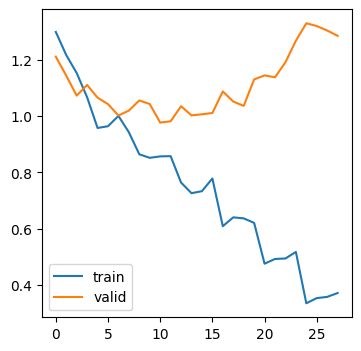

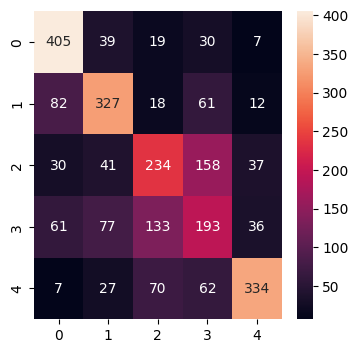

In [99]:
net1 = Net1()

net_trained1, loss_train1, loss_valid1 = run_training(net = net1, lr = 1e-3, batch_size = 16, epochs = 7)

print('-'*40,'Figure 2', '-'*40)
plt.figure()
plt.plot(loss_train1, label = 'train')
plt.plot(loss_valid1, label = 'valid')
plt.xlabel('iteration (*100)')
plt.ylabel('training loss')
plt.legend()

plt.figure()
run_validation(net_trained1)

[epoch: 1, batch: 100] train loss: 1.313 ******** valid loss: 1.141
[epoch: 1, batch: 200] train loss: 1.117 ******** valid loss: 1.091
[epoch: 1, batch: 300] train loss: 1.100 ******** valid loss: 1.026
[epoch: 1, batch: 400] train loss: 1.041 ******** valid loss: 1.033
[epoch: 2, batch: 100] train loss: 0.922 ******** valid loss: 1.101
[epoch: 2, batch: 200] train loss: 0.918 ******** valid loss: 0.987
[epoch: 2, batch: 300] train loss: 0.932 ******** valid loss: 1.095
[epoch: 2, batch: 400] train loss: 0.934 ******** valid loss: 1.023
[epoch: 3, batch: 100] train loss: 0.797 ******** valid loss: 1.030
[epoch: 3, batch: 200] train loss: 0.813 ******** valid loss: 1.055
[epoch: 3, batch: 300] train loss: 0.833 ******** valid loss: 1.053
[epoch: 3, batch: 400] train loss: 0.794 ******** valid loss: 0.952
[epoch: 4, batch: 100] train loss: 0.684 ******** valid loss: 0.955
[epoch: 4, batch: 200] train loss: 0.674 ******** valid loss: 1.074
[epoch: 4, batch: 300] train loss: 0.692 *******

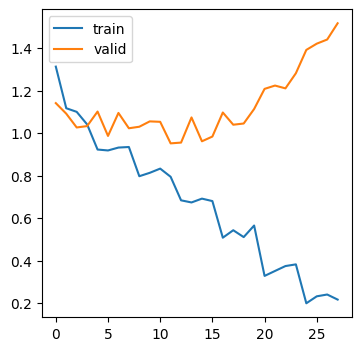

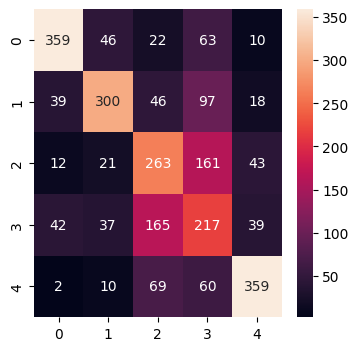

In [101]:
net2 = Net2()

net_trained2, loss_train2, loss_valid2 = run_training(net = net2, lr = 1e-3, batch_size = 16, epochs = 7)

print('-'*40,'Figure 2', '-'*40)
plt.figure()
plt.plot(loss_train2, label = 'train')
plt.plot(loss_valid2, label = 'valid')
plt.xlabel('iteration (*100)')
plt.ylabel('training loss')
plt.legend()

plt.figure()
run_validation(net_trained2)

model accuracy =  0.5992


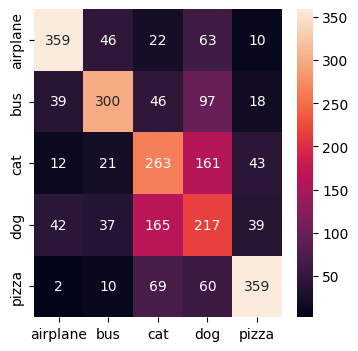

In [112]:
plt.figure()
run_validation(net_trained2)

[epoch: 1, batch: 100] train loss: 1.535 ******** valid loss: 1.446
[epoch: 1, batch: 200] train loss: 1.415 ******** valid loss: 1.370
[epoch: 1, batch: 300] train loss: 1.328 ******** valid loss: 1.341
[epoch: 1, batch: 400] train loss: 1.343 ******** valid loss: 1.333
[epoch: 2, batch: 100] train loss: 1.299 ******** valid loss: 1.323
[epoch: 2, batch: 200] train loss: 1.327 ******** valid loss: 1.359
[epoch: 2, batch: 300] train loss: 1.295 ******** valid loss: 1.327
[epoch: 2, batch: 400] train loss: 1.316 ******** valid loss: 1.300
[epoch: 3, batch: 100] train loss: 1.343 ******** valid loss: 1.347
[epoch: 3, batch: 200] train loss: 1.289 ******** valid loss: 1.272
[epoch: 3, batch: 300] train loss: 1.275 ******** valid loss: 1.268
[epoch: 3, batch: 400] train loss: 1.232 ******** valid loss: 1.240
[epoch: 4, batch: 100] train loss: 1.236 ******** valid loss: 1.223
[epoch: 4, batch: 200] train loss: 1.230 ******** valid loss: 1.239
[epoch: 4, batch: 300] train loss: 1.188 *******

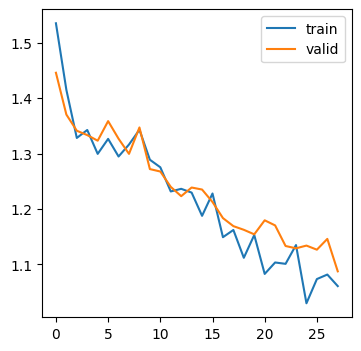

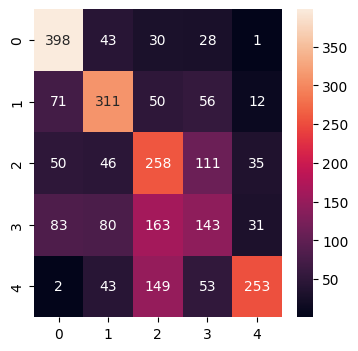

In [102]:
net3 = Net3()

net_trained3, loss_train3, loss_valid3 = run_training(net = net3, lr = 1e-3, batch_size = 16, epochs = 7)

print('-'*40,'Figure 2', '-'*40)
plt.figure()
plt.plot(loss_train3, label = 'train')
plt.plot(loss_valid3, label = 'valid')
plt.xlabel('iteration (*100)')
plt.ylabel('training loss')
plt.legend()

plt.figure()
run_validation(net_trained3)

### Compare the loss vs iteration curve for three net

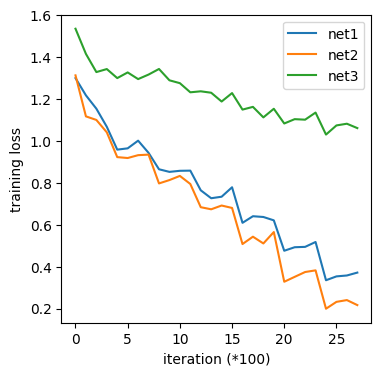

In [115]:
plt.figure()
plt.plot(loss_train1, label = 'net1')
plt.plot(loss_train2, label = 'net2')
plt.plot(loss_train3, label = 'net3')
plt.xlabel('iteration (*100)')
plt.ylabel('training loss')
plt.legend()
plt.show()

### Conclusion
1. Compared the results from Net2 and Net1, Adding padding to the convolutional layers reduces the loss and increases the accuracy, but the effect is relative small.
2. In the Net3, I naively add 10 more layers compared to Net2. The training loss reduces at the slower speed compared to Net2. This is probably caused by the vanishing gradient.
3. From my implementation, Net2 produces the best result. 
4. From the confusion matrix, the dog and cat are two categories that are more likely to be misclassified. The reason is that cat and dog have several common features. For example, they are both animals with two eyes, hairs, four legs etc. For other categories, pizza, bus, plane has their own distinct features, therefore are easier to be correctly classified.
5. One way to get better classification accuracy than Net2 is to add more nuerual layers with dropout and normalization. Another way is to increase the image resolution better than 64*64, the feature will be easier to be visualized and the classification model will be more accurate.  

# Try more, add data augmentation with random affine transform
- Without data augmentation, the training loss and validation loss are very different, that is a indication of overfitting.
- With data augmentation, the training loss and validation loss have similar trends and the model produces a better classification accuracy.

[epoch: 1, batch: 100] train loss: 1.423 ******** valid loss: 1.302 ******** valid accu: 0.452
[epoch: 1, batch: 200] train loss: 1.273 ******** valid loss: 1.276 ******** valid accu: 0.475
[epoch: 1, batch: 300] train loss: 1.272 ******** valid loss: 1.217 ******** valid accu: 0.500
[epoch: 1, batch: 400] train loss: 1.198 ******** valid loss: 1.194 ******** valid accu: 0.515
[epoch: 2, batch: 100] train loss: 1.188 ******** valid loss: 1.155 ******** valid accu: 0.530
[epoch: 2, batch: 200] train loss: 1.165 ******** valid loss: 1.191 ******** valid accu: 0.518
[epoch: 2, batch: 300] train loss: 1.109 ******** valid loss: 1.133 ******** valid accu: 0.556
[epoch: 2, batch: 400] train loss: 1.119 ******** valid loss: 1.223 ******** valid accu: 0.513
[epoch: 3, batch: 100] train loss: 1.090 ******** valid loss: 1.136 ******** valid accu: 0.548
[epoch: 3, batch: 200] train loss: 1.071 ******** valid loss: 1.106 ******** valid accu: 0.560
[epoch: 3, batch: 300] train loss: 1.078 ******** 

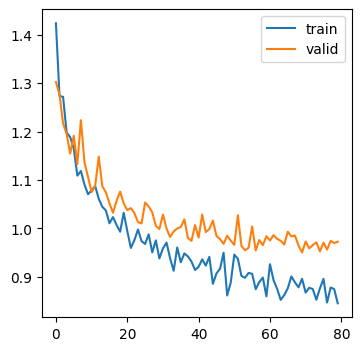

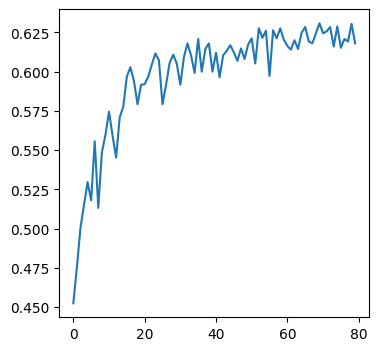

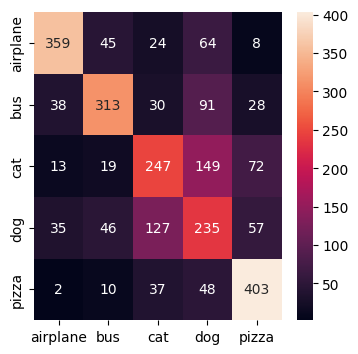

In [39]:
net1 = Net1()

net_trained1, loss_train1, loss_valid1, accu_valid1 = run_training(net = net1, lr = 1e-3, batch_size = 16, epochs = 20)

print('-'*40,'Figure 2', '-'*40)
plt.figure()
plt.plot(loss_train1, label = 'train')
plt.plot(loss_valid1, label = 'valid')
plt.xlabel('iteration (*100)')
plt.ylabel('training loss')
plt.legend()

plt.figure()
plt.plot(accu_valid1)
plt.xlabel('iteration (*100)')
plt.ylabel('validation accuracy')

plt.figure()
run_validation(net_trained1)

[epoch: 1, batch: 100] train loss: 1.454 ******** valid loss: 1.269 ******** valid accu: 0.476
[epoch: 1, batch: 200] train loss: 1.341 ******** valid loss: 1.208 ******** valid accu: 0.512
[epoch: 1, batch: 300] train loss: 1.215 ******** valid loss: 1.184 ******** valid accu: 0.528
[epoch: 1, batch: 400] train loss: 1.200 ******** valid loss: 1.153 ******** valid accu: 0.543
[epoch: 2, batch: 100] train loss: 1.151 ******** valid loss: 1.076 ******** valid accu: 0.579
[epoch: 2, batch: 200] train loss: 1.113 ******** valid loss: 1.019 ******** valid accu: 0.603
[epoch: 2, batch: 300] train loss: 1.078 ******** valid loss: 1.024 ******** valid accu: 0.590
[epoch: 2, batch: 400] train loss: 1.078 ******** valid loss: 1.049 ******** valid accu: 0.589
[epoch: 3, batch: 100] train loss: 0.977 ******** valid loss: 0.999 ******** valid accu: 0.601
[epoch: 3, batch: 200] train loss: 1.093 ******** valid loss: 0.974 ******** valid accu: 0.618
[epoch: 3, batch: 300] train loss: 1.057 ******** 

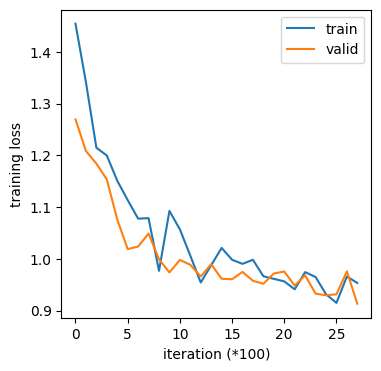

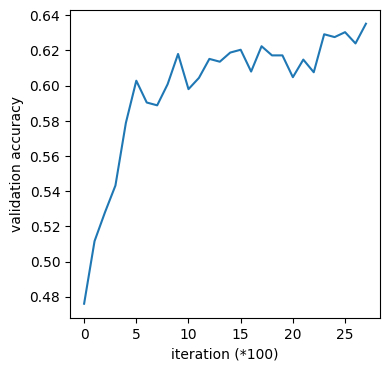

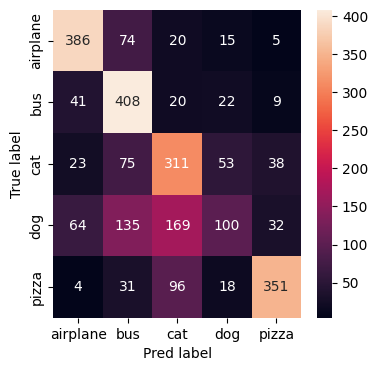

In [16]:
net1 = Net1()

net_trained1, loss_train1, loss_valid1, accu_valid1 = run_training(net = net1, lr = 5e-3, batch_size = 16, epochs = 7)

print('-'*40,'Figure 2', '-'*40)
plt.figure()
plt.plot(loss_train1, label = 'train')
plt.plot(loss_valid1, label = 'valid')
plt.xlabel('iteration (*100)')
plt.ylabel('training loss')
plt.legend()

plt.figure()
plt.plot(accu_valid1)
plt.xlabel('iteration (*100)')
plt.ylabel('validation accuracy')

plt.figure()
run_validation(net_trained1)

[epoch: 1, batch: 100] train loss: 1.424 ******** valid loss: 1.283 ******** valid accu: 0.457
[epoch: 1, batch: 200] train loss: 1.300 ******** valid loss: 1.230 ******** valid accu: 0.497
[epoch: 1, batch: 300] train loss: 1.249 ******** valid loss: 1.182 ******** valid accu: 0.518
[epoch: 1, batch: 400] train loss: 1.188 ******** valid loss: 1.120 ******** valid accu: 0.554
[epoch: 2, batch: 100] train loss: 1.160 ******** valid loss: 1.115 ******** valid accu: 0.551
[epoch: 2, batch: 200] train loss: 1.113 ******** valid loss: 1.044 ******** valid accu: 0.588
[epoch: 2, batch: 300] train loss: 1.066 ******** valid loss: 1.053 ******** valid accu: 0.570
[epoch: 2, batch: 400] train loss: 1.110 ******** valid loss: 1.054 ******** valid accu: 0.571
[epoch: 3, batch: 100] train loss: 1.085 ******** valid loss: 1.079 ******** valid accu: 0.553
[epoch: 3, batch: 200] train loss: 1.060 ******** valid loss: 1.000 ******** valid accu: 0.611
[epoch: 3, batch: 300] train loss: 1.040 ******** 

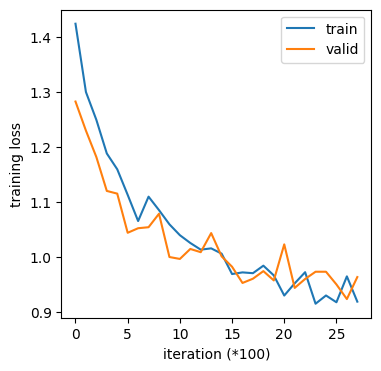

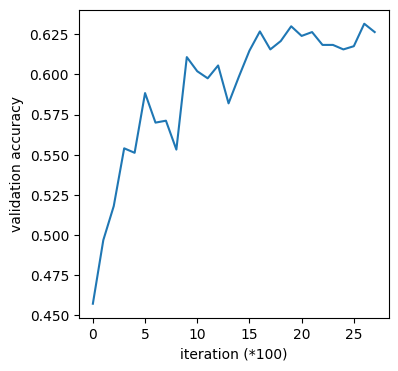

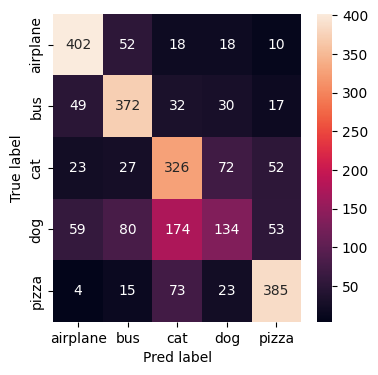

In [17]:
net2 = Net2()

net_trained2, loss_train2, loss_valid2, accu_valid2 = run_training(net = net2, lr = 5e-3, batch_size = 16, epochs = 7)

print('-'*40,'Figure 2', '-'*40)
plt.figure()
plt.plot(loss_train2, label = 'train')
plt.plot(loss_valid2, label = 'valid')
plt.xlabel('iteration (*100)')
plt.ylabel('training loss')
plt.legend()

plt.figure()
plt.plot(accu_valid2)
plt.xlabel('iteration (*100)')
plt.ylabel('validation accuracy')

plt.figure()
run_validation(net_trained2)

[epoch: 1, batch: 100] train loss: 1.594 ******** valid loss: 1.554 ******** valid accu: 0.273
[epoch: 1, batch: 200] train loss: 1.501 ******** valid loss: 1.452 ******** valid accu: 0.356
[epoch: 1, batch: 300] train loss: 1.413 ******** valid loss: 1.413 ******** valid accu: 0.380
[epoch: 1, batch: 400] train loss: 1.394 ******** valid loss: 1.338 ******** valid accu: 0.418
[epoch: 2, batch: 100] train loss: 1.375 ******** valid loss: 1.383 ******** valid accu: 0.440
[epoch: 2, batch: 200] train loss: 1.300 ******** valid loss: 1.285 ******** valid accu: 0.444
[epoch: 2, batch: 300] train loss: 1.264 ******** valid loss: 1.327 ******** valid accu: 0.452
[epoch: 2, batch: 400] train loss: 1.286 ******** valid loss: 1.260 ******** valid accu: 0.474
[epoch: 3, batch: 100] train loss: 1.247 ******** valid loss: 1.255 ******** valid accu: 0.472
[epoch: 3, batch: 200] train loss: 1.297 ******** valid loss: 1.231 ******** valid accu: 0.471
[epoch: 3, batch: 300] train loss: 1.271 ******** 

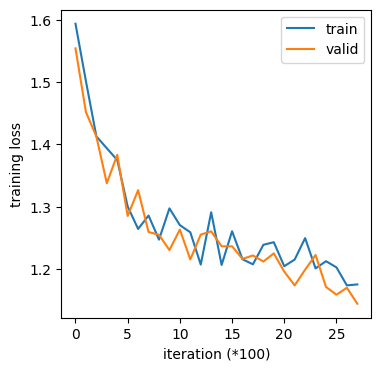

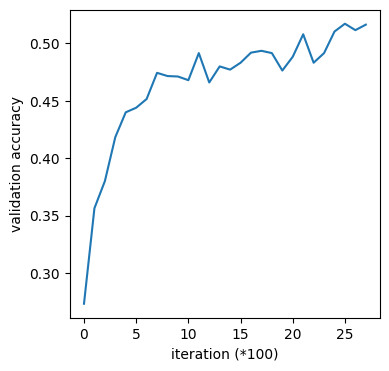

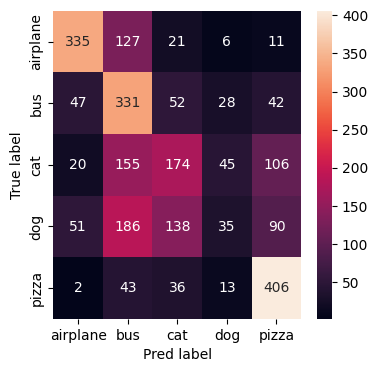

In [18]:
net3 = Net3()

net_trained3, loss_train3, loss_valid3, accu_valid3 = run_training(net = net3, lr = 5e-3, batch_size = 16, epochs = 7)

# print('-'*40,'Figure 2', '-'*40)
plt.figure()
plt.plot(loss_train3, label = 'train')
plt.plot(loss_valid3, label = 'valid')
plt.xlabel('iteration (*100)')
plt.ylabel('training loss')
plt.legend()

plt.figure()
plt.plot(accu_valid3)
plt.xlabel('iteration (*100)')
plt.ylabel('validation accuracy')

plt.figure()
run_validation(net_trained3)

### Compare the loss vs iteration curve for three net

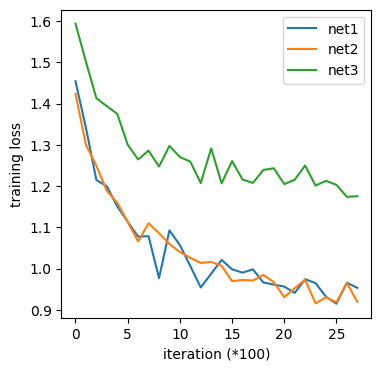

In [19]:
plt.figure()
plt.plot(loss_train1, label = 'net1')
plt.plot(loss_train2, label = 'net2')
plt.plot(loss_train3, label = 'net3')
plt.xlabel('iteration (*100)')
plt.ylabel('training loss')
plt.legend()
plt.show()

### Compare the validation accuracy vs iteration curve for three net

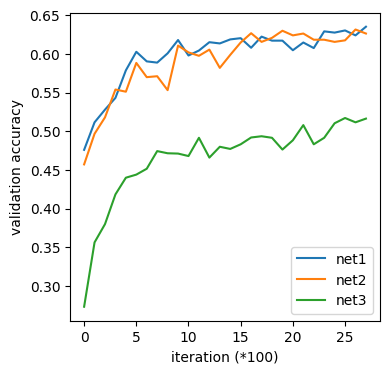

In [20]:
plt.figure()
plt.plot(accu_valid1, label = 'net1')
plt.plot(accu_valid2, label = 'net2')
plt.plot(accu_valid3, label = 'net3')
plt.xlabel('iteration (*100)')
plt.ylabel('validation accuracy')
plt.legend()
plt.show()